## Forecasting Stock Prices using ARIMA (Time-Series)

### Using time series in ml and ARIMA

In [35]:
import statsmodels.api as sm
import numpy as np 
import yfinance as yf
import pandas as pd
from datetime import datetime,timedelta
import matplotlib.pyplot as plt 
import seaborn as sns
import os

Loading data from yfinance -- here apple(AAPL)

In [36]:
ticker='AAPL'
df=yf.download(ticker,start='2015-01-01',end='2025-11-30')
df.head()

C:\Users\anshc\AppData\Local\Temp\ipykernel_11428\66940133.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df=yf.download(ticker,start='2015-01-01',end='2025-11-30')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.237558,24.705328,23.798608,24.694243,212818400
2015-01-05,23.554737,24.086797,23.368517,24.006988,257142000
2015-01-06,23.556957,23.816336,23.195599,23.619031,263188400
2015-01-07,23.887281,23.987042,23.654504,23.765350,160423600
2015-01-08,24.805084,24.862725,24.097887,24.215385,237458000


In [37]:
df.columns=df.columns.droplevel(1)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2744 entries, 2015-01-02 to 2025-11-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2744 non-null   float64
 1   High    2744 non-null   float64
 2   Low     2744 non-null   float64
 3   Open    2744 non-null   float64
 4   Volume  2744 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 128.6 KB


In [39]:
df.columns.name=None
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,24.237558,24.705328,23.798608,24.694243,212818400
2015-01-05,23.554737,24.086797,23.368517,24.006988,257142000
2015-01-06,23.556957,23.816336,23.195599,23.619031,263188400
2015-01-07,23.887281,23.987042,23.654504,23.765350,160423600
2015-01-08,24.805084,24.862725,24.097887,24.215385,237458000


In [40]:
df.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [41]:
df.sort_index()

,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,24.237558,24.705328,23.798608,24.694243,212818400
2015-01-05,23.554737,24.086797,23.368517,24.006988,257142000
2015-01-06,23.556957,23.816336,23.195599,23.619031,263188400
2015-01-07,23.887281,23.987042,23.654504,23.765350,160423600
2015-01-08,24.805084,24.862725,24.097887,24.215385,237458000
...,...,...,...,...,...
2025-11-21,271.489990,273.329987,265.670013,265.950012,59030800
2025-11-24,275.920013,277.000000,270.899994,270.899994,65585800
2025-11-25,276.970001,280.380005,275.250000,275.269989,46914200


Not assigning the sorted index back as the values already follow DateTimeIndex and seem to be sorted already.

This is good since there are no null values.

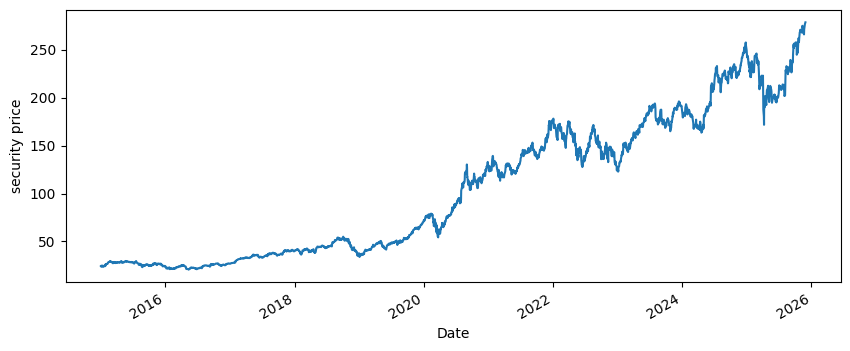

In [42]:
ts=df[('Close')]
ts.plot(figsize=(10,4))
plt.ylabel('security price')
plt.show()

## Prepare Data for ARIMA

### Resample the data to get stock closing prices aggregated on a weekly basis.

In [43]:
df_week=df.resample('W').mean()
df_week=df_week[['Close']]
df_week.head()

,Close
Date,
2015-01-04,24.237558
2015-01-11,24.127149
2015-01-18,24.034924
2015-01-25,24.588380
2015-02-01,25.432911


### Creating a column for weekly returns. Take log of the returns to normalize fluctuations.

In [44]:
df_week['weekly_r']=np.log(df_week['Close']).diff()
df_week['weekly_r'].head()

Date
2015-01-04         NaN
2015-01-11   -0.004566
2015-01-18   -0.003830
2015-01-25    0.022766
2015-02-01    0.033770
Freq: W-SUN, Name: weekly_r, dtype: float64

#### Drop null rows

In [45]:
df_week.dropna(inplace=True)

<Axes: xlabel='Date'>

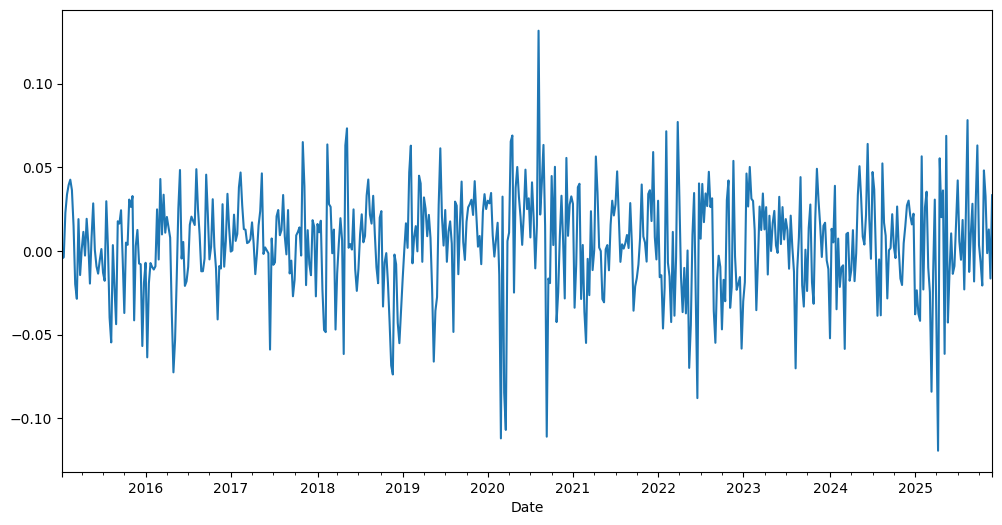

In [46]:
df_week.weekly_r.plot(kind='line',figsize=(12,6))

In [47]:
udiff=df_week.drop(['Close'],axis=1)
udiff.head()

,weekly_r
Date,
2015-01-11,-0.004566
2015-01-18,-0.003830
2015-01-25,0.022766
2015-02-01,0.033770
2015-02-08,0.039386


### Test for Stationarity of udiff

In [48]:
from statsmodels.tsa.stattools import adfuller

In [49]:
rolmean=udiff.rolling(20).mean()
rolstd=udiff.rolling(20).std()

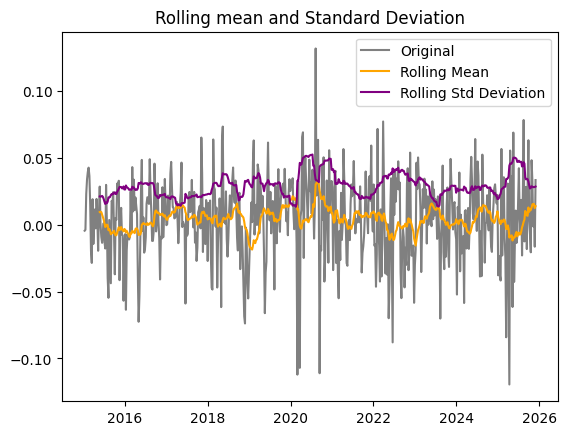

In [50]:
plt.Figure(figsize=(18,8))
orig=plt.plot(udiff,color='grey',label='Original')
mean=plt.plot(rolmean,color='orange',label='Rolling Mean')
std=plt.plot(rolstd,color='purple',label='Rolling Std Deviation')
plt.title('Rolling mean and Standard Deviation')
plt.legend(loc='best')
plt.show()

### Dickey-Fuller Test

In [51]:
dftest=sm.tsa.adfuller(udiff.weekly_r,autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-vlaue','#Lags used','Number of Observations used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value ({0})'.format(key)]=value
dfoutput    

Test Statistic                -1.854710e+01
p-vlaue                        2.094468e-30
#Lags used                     0.000000e+00
Number of Observations used    5.680000e+02
Critical Value (1%)           -3.441915e+00
Critical Value (5%)           -2.866642e+00
Critical Value (10%)          -2.569487e+00
dtype: float64

### Since p-value < 0.05, we reject null hypothesis and conclude that our data is stationary.

#### Now some Autocorrelation(ACF) and partial Autocorrelation(PACF) charts to help us choose hyperparameteres for our model.

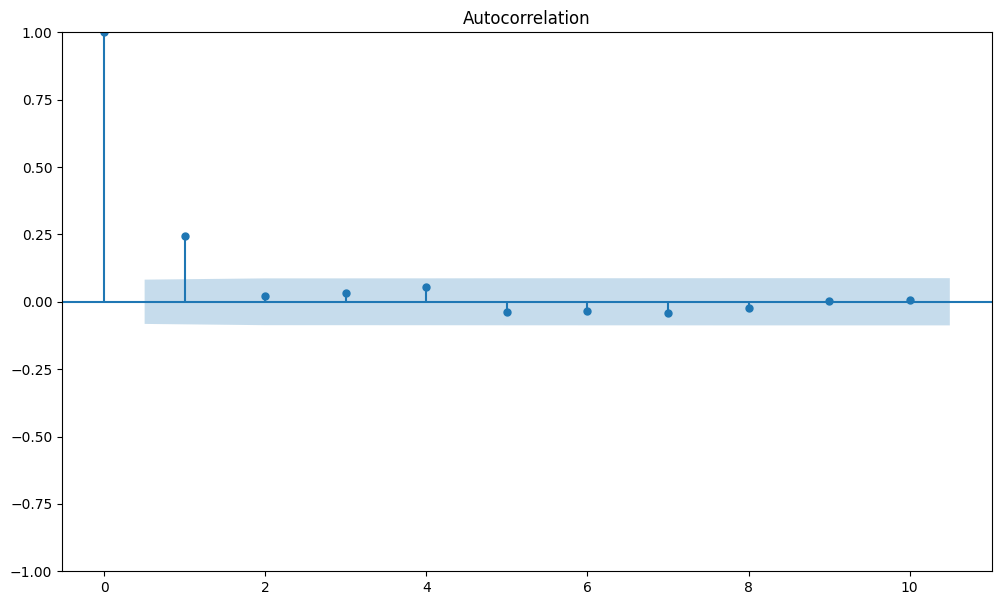

In [52]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
# the autocorrelation chart provides just the correaltion at increasing lags
fig,ax=plt.subplots(figsize=(12,7))
plot_acf(udiff.values,lags=10,ax=ax)
plt.show()

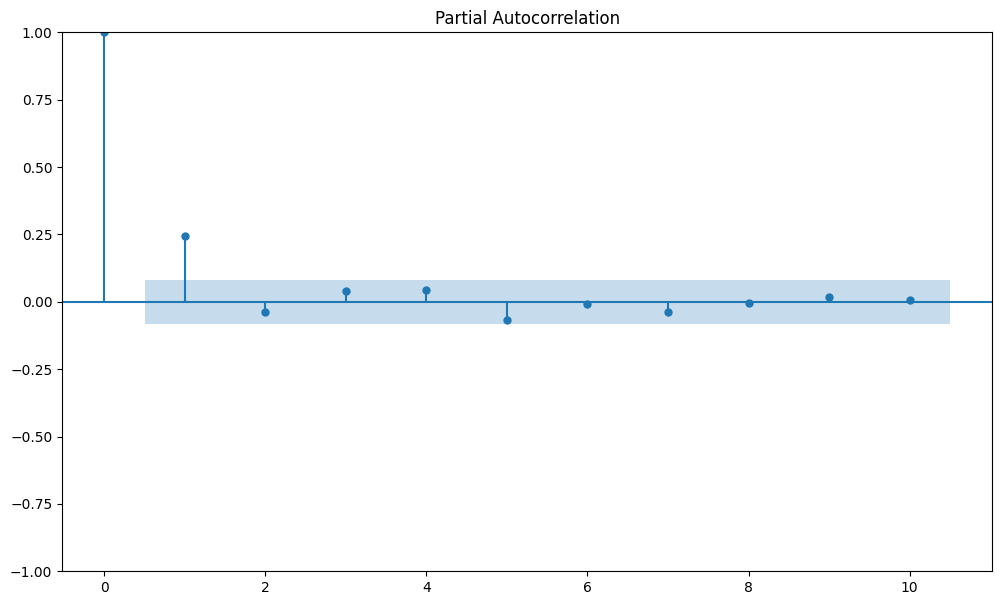

In [53]:
fig,ax=plt.subplots(figsize=(12,7))
plot_pacf(udiff.values,lags=10,ax=ax)
plt.show()

##### The hyperparameter for ACF(p value=1) and PACF(q value=1). 

### One way to evaluate the model is to look at AIC -see if it increases or decreases. The lower the AIC the better i.e the more negative the AIC the better the model.
AIC- Akaike Information Criterion

### Now we build our model.

In [54]:
from statsmodels.tsa.arima.model import ARIMA

ar1=ARIMA(udiff.values,order=(1,0,1),trend='n').fit()
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  569
Model:                 ARIMA(1, 0, 1)   Log Likelihood                1192.388
Date:                Thu, 25 Dec 2025   AIC                          -2378.776
Time:                        22:36:15   BIC                          -2365.744
Sample:                             0   HQIC                         -2373.691
                                - 569                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1406      0.149      0.946      0.344      -0.151       0.432
ma.L1          0.1258      0.143      0.881      0.378      -0.154       0.406
sigma2         0.0009   4.13e-05     21.451      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                62.24
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.72   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Lets see how our model is doing.

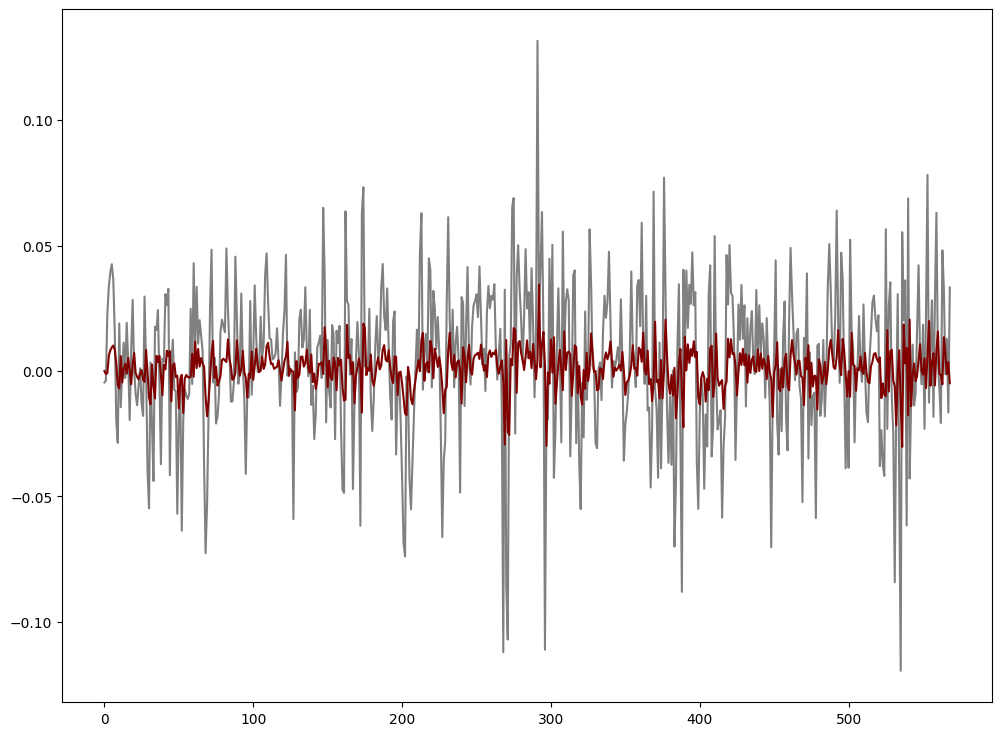

In [55]:
plt.figure(figsize=(12,9))
plt.plot(udiff.values,color='grey')
preds=ar1.fittedvalues
plt.plot(preds,color='maroon')
plt.show()

##### Model does a good job predicting direction, but a poor job when it comes to variance.

# Let's make a forecast 4 weeks into the future.

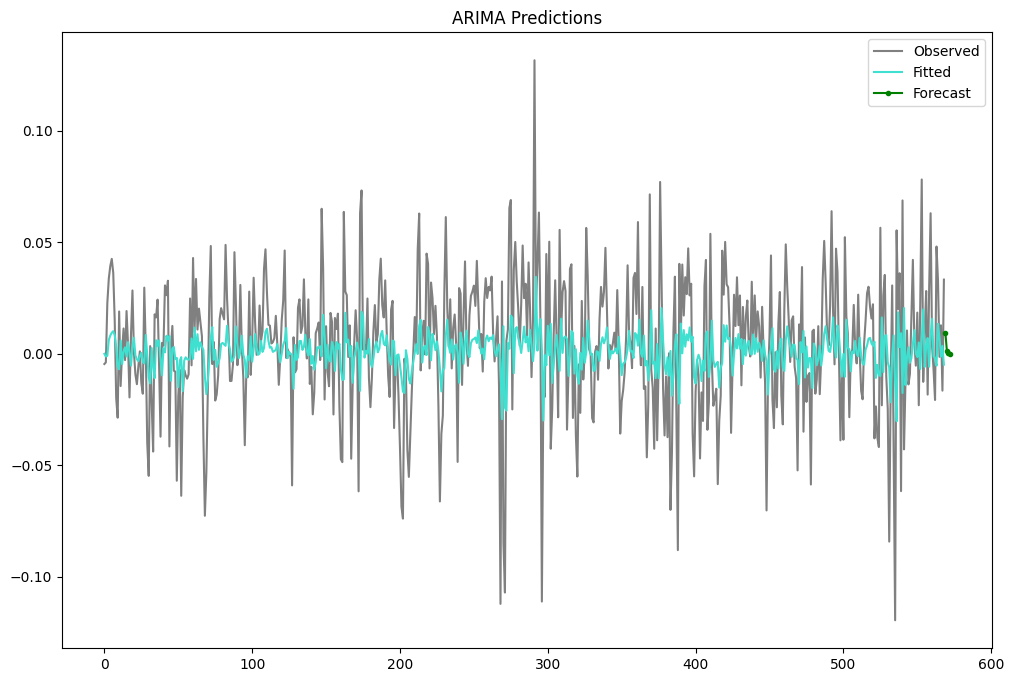

In [56]:
# Forecast next 4 steps
steps = 4
forecast = ar1.forecast(steps=steps)

# Plot original series
plt.figure(figsize=(12,8))
plt.plot(udiff.values, color='grey', label='Observed')

# Plot fitted values
preds = ar1.fittedvalues
plt.plot(preds, color='turquoise', label='Fitted')

# Plot forecast
forecast_index = np.arange(len(udiff.values), len(udiff.values) + steps)
plt.plot(forecast_index, forecast, color='green',marker='.', label='Forecast')

plt.title('ARIMA Predictions')
plt.legend()
plt.show()

## We cannot decide if the model performs well based on just one AIC of one model, So we take SARIMA the seasonal model as well as Garch.

### SARIMA

In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

ar2=SARIMAX(udiff.values,order=(1,0,1),seasonal_order=(1,0,1,52),enforce_invertibility=False,enforce_stationarity=False).fit()
ar2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  569
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 52)   Log Likelihood                1070.830
Date:                            Thu, 25 Dec 2025   AIC                          -2131.659
Time:                                    22:36:20   BIC                          -2110.438
Sample:                                         0   HQIC                         -2123.343
                                            - 569                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1691      0.160      1.056      0.291      -0.145       0.483
ma.L1          0.0941      0.155      0.607      0.544      -0.210       0.398
ar.S.L52      -0.1168      0.232     -0.503      0.615      -0.572       0.338
ma.S.L52       0.0480      0.238      0.202      0.840      -0.418       0.515
sigma2         0.0009   4.67e-05     19.567      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                52.27
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               1.54   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Garch

In [58]:
from arch import arch_model
ar3=arch_model(udiff.values,
    mean='AR',
    lags=1,
    vol='Garch',
    p=1,
    q=1).fit()
ar3.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 117840431.56152454
Iteration:      2,   Func. Count:     19,   Neg. LLF: 907.1638436803676
Iteration:      3,   Func. Count:     29,   Neg. LLF: 4263435121647.1445
Iteration:      4,   Func. Count:     40,   Neg. LLF: 2907794.511994402
Iteration:      5,   Func. Count:     50,   Neg. LLF: 80313827426.44928
Iteration:      6,   Func. Count:     60,   Neg. LLF: 249.25245330950582
Iteration:      7,   Func. Count:     69,   Neg. LLF: -1108.1237307444158
Iteration:      8,   Func. Count:     77,   Neg. LLF: -1112.911268277736
Iteration:      9,   Func. Count:     84,   Neg. LLF: -982.9938781568316
Iteration:     10,   Func. Count:     92,   Neg. LLF: 4287205915896767.5
Iteration:     11,   Func. Count:    104,   Neg. LLF: 17700.47479453592
Iteration:     12,   Func. Count:    114,   Neg. LLF: -252.37859237576743
Iteration:     13,   Func. Count:    123,   Neg. LLF: -1189.8346455678297
Iteration:     14,   Func. Count:    130,   Neg. LLF

c:\Users\anshc\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008776. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                      y   R-squared:                       0.056
Mean Model:                        AR   Adj. R-squared:                  0.055
Vol Model:                      GARCH   Log-Likelihood:                1210.05
Distribution:                  Normal   AIC:                          -2410.09
Method:            Maximum Likelihood   BIC:                          -2388.38
                                        No. Observations:                  568
Date:                Thu, Dec 25 2025   Df Residuals:                      566
Time:                        22:36:24   Df Model:                            2
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
Const      3.5129e-03  1.278e-03      2.748  5.997e-03 [1.007e-03,6.018e-03]
y[1]           0.2951  4.498e-02      6.560  5.370e-11     [  0.207,  0.383]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.3737e-05  2.074e-05      3.073  2.120e-03 [2.308e-05,1.044e-04]
alpha[1]       0.0740  2.804e-02      2.639  8.306e-03   [1.905e-02,  0.129]
beta[1]        0.8536  4.330e-02     19.715  1.596e-86     [  0.769,  0.938]
============================================================================

Covariance estimator: robust
"""

I tried out SARIMA and Garch on AI's recommedation and turns out Garch performs better because Garch models volatility clustering and ARIMA models calendar patterns, togther with arch they achieve much more than their individual parts.

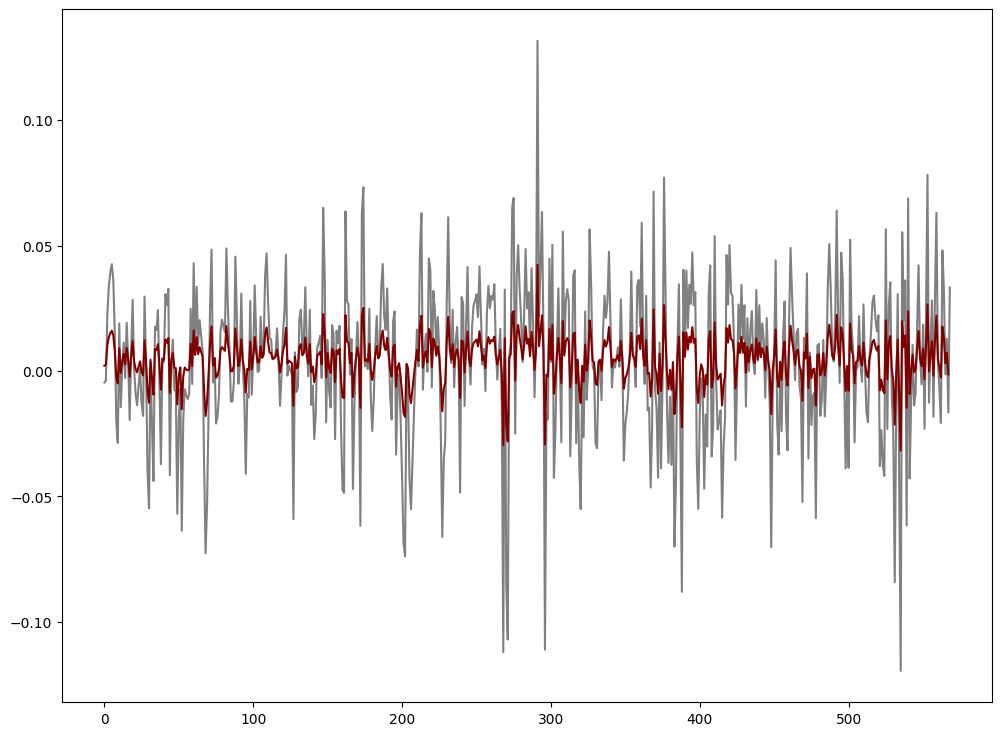

In [59]:
plt.figure(figsize=(12,9))
plt.plot(udiff.values,color='grey')
preds = ar3.params['Const'] + ar3.params['y[1]'] * udiff.values[:-1]
plt.plot(preds,color='maroon')
plt.show()

ARIMA → predicts the series

GARCH → models conditional mean + conditional variance

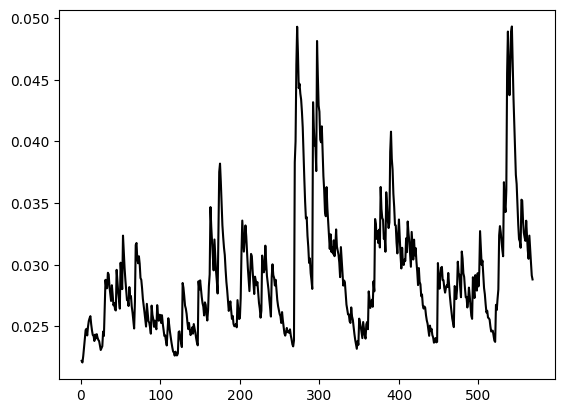

In [60]:
vol = ar3.conditional_volatility
plt.plot(vol,color='black')


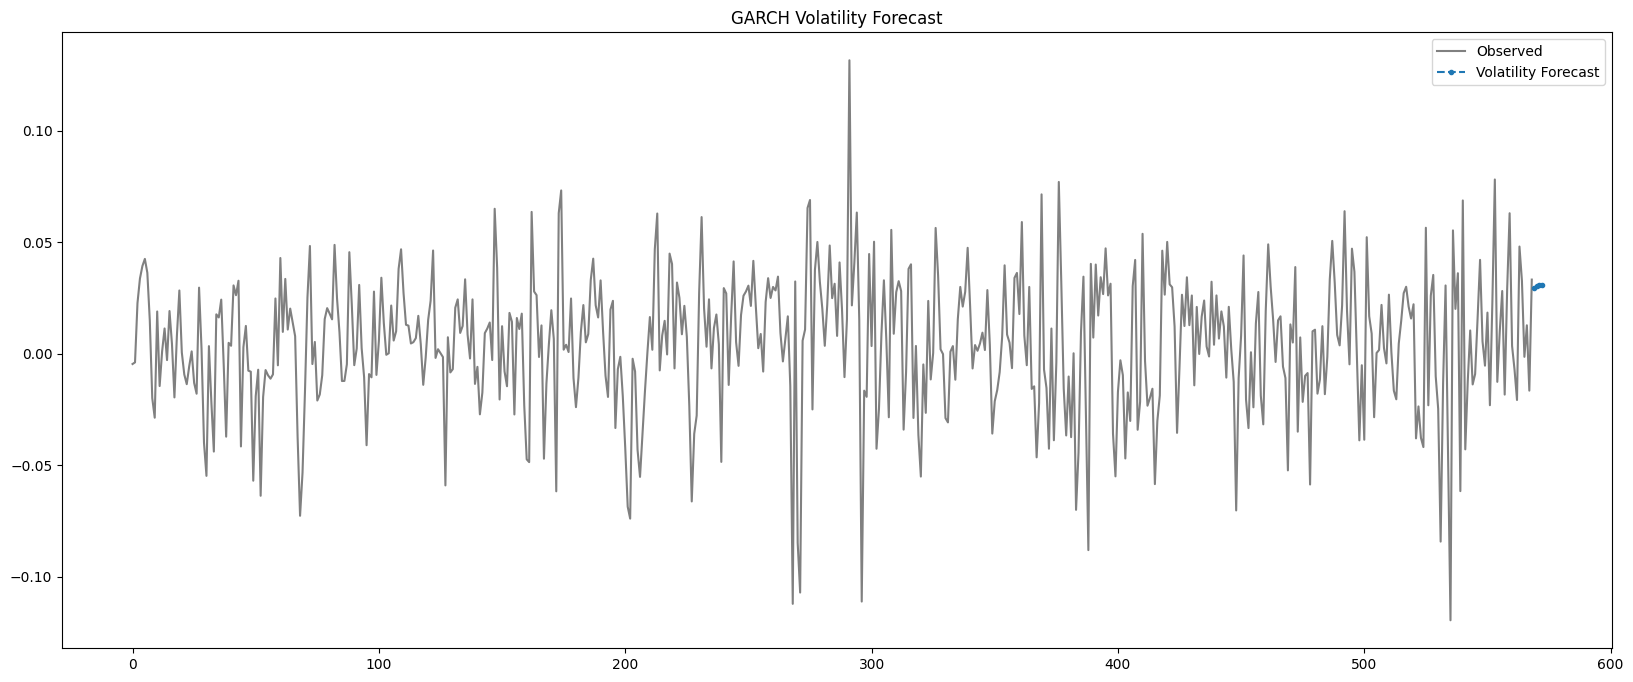

In [65]:
res = ar3

# Forecast next 4 steps
horizon = 4
fcst = res.forecast(horizon=horizon)

# Variance / volatility forecast 
var_fc = fcst.variance.iloc[-1].values
vol_fc = np.sqrt(var_fc)

# Plot
plt.figure(figsize=(20,8))
plt.plot(udiff.values, color='grey', label='Observed')

forecast_index = np.arange(len(udiff), len(udiff) + horizon)

plt.plot(forecast_index, vol_fc, marker='.', linestyle='--', label='Volatility Forecast')

plt.title('GARCH Volatility Forecast')
plt.legend()
plt.show()

## In Conclusion, based on the AIC values of the three, Garch is the clear winner. Though Garch is volatility based and Arima follows a time series.

Think of it this way:

* ARIMA predicts the road.
* GARCH predicts the potholes.